In [1]:
!pip install evaluate
!pip install --upgrade datasets
!pip install wandb
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [2]:
import pandas as pd
import ast
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from datasets import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score, precision_score, recall_score, classification_report
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, DataCollatorWithPadding
import wandb
wandb.login()
import os
# Keep if you intend to use wandb; remove/set to "true" if not.
os.environ["WANDB_DISABLED"] = "false"

print("All installations and imports processed.")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: finnegan-nessa (finnegan-nessa-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


All installations and imports processed.


In [3]:
# Keep if you intend to use
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# --- Constants and Mappings ---
GOEMOTIONS_LABELS = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
    'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment',
    'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
    'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

GOEMOTIONS_ID_TO_LABEL = {
    0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion',
    7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment',
    13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness',
    20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise'
}

In [5]:
# --- Data Parsing and Loading Functions ---
def parse_synthetic_emotion_string(emotion_str):
    """
    Parses a string representation of a list of emotions into an actual list.
    Handles potential 'neutral' or empty lists, and single string emotions.
    """
    if pd.isna(emotion_str):
        return ['neutral']

    try:
        parsed_list = ast.literal_eval(emotion_str)
        if isinstance(parsed_list, list):
            return parsed_list if parsed_list else ['neutral']
        else:
            return [str(parsed_list)] if str(parsed_list).strip() else ['neutral']
    except (ValueError, SyntaxError):

        if emotion_str.strip():
            return [emotion_str.strip()]
        else:
            return ['neutral']


In [6]:
def load_and_process_go_emotions_split(filepath):

    """
    Loads and processes a GoEmotions TSV split, assigning 'neutral' where no other emotions are found.
    """
    try:
        df_split = pd.read_csv(filepath, sep='\t', encoding='utf-8', header=None, names=['text', 'emotion_ids_str', 'comment_id'])
        print(f"Loaded {filepath.split('/')[-1]}. Initial shape: {df_split.shape}")
        print(f"Columns in {filepath.split('/')[-1]} after initial load: {df_split.columns.tolist()}")

        df_split['emotion_ids_list'] = df_split['emotion_ids_str'].apply(
            lambda x: [int(label_id) for label_id in str(x).split(',') if label_id.strip().isdigit()]
        )

        df_split['emotion_names_raw'] = df_split['emotion_ids_list'].apply(
            lambda ids: [GOEMOTIONS_ID_TO_LABEL[idx] for idx in ids if idx in GOEMOTIONS_ID_TO_LABEL]
        )

        df_split['emotion'] = df_split['emotion_names_raw'].apply(
            lambda x: ['neutral'] if not x else x
        )
        # Assign 'neutral' where no other emotions are found
        df_processed = df_split[['text', 'emotion']].copy()
        print(f"Processed {filepath.split('/')[-1]}. Final shape: {df_processed.shape}")
        return df_processed
    except FileNotFoundError:
        print(f"Error: {filepath.split('/')[-1]} not found. Please ensure all 3 GoEmotions TSV files are in the specified Drive path.")
        return pd.DataFrame(columns=['text', 'emotion'])
    except Exception as e:
        print(f"An error occurred loading or processing {filepath.split('/')[-1]}: {e}")
        return pd.DataFrame(columns=['text', 'emotion'])

In [47]:
# --- Data Paths ---
# IMPORTANT: Update these paths to where you've stored your data.
# These paths are relative to where you run this script.
# Ensure your 'data' folder is structured as:
# data/
# ├── go-emotions/
# │   ├── train.tsv
# │   ├── dev.tsv
# │   └── test.tsv
# └── synthetic/
#     └── synthetic-emotion-data.csv (or your synthetic data file name)
go_emotions_data_path = "/content/drive/MyDrive/ML_Emotion_Classifier/data/go_emotions/"
go_emotions_train_filepath = f"{go_emotions_data_path}train.tsv"
go_emotions_dev_filepath = f"{go_emotions_data_path}dev.tsv"
go_emotions_test_filepath = f"{go_emotions_data_path}test.tsv"

synthetic_data_filepath = "/content/drive/MyDrive/ML_Emotion_Classifier/data/synthetic-emotion-data.csv"

In [48]:
print("--- Loading and processing official GoEmotions splits ---")
df_go_emotions_train = load_and_process_go_emotions_split(go_emotions_train_filepath)
print(f"Shape of df_go_emotions_train after processing: {df_go_emotions_train.shape}")
df_go_emotions_val = load_and_process_go_emotions_split(go_emotions_dev_filepath)
df_go_emotions_test = load_and_process_go_emotions_split(go_emotions_test_filepath)
print("--------------------------------------------------------------------------------")

--- Loading and processing official GoEmotions splits ---
Loaded train.tsv. Initial shape: (43410, 3)
Columns in train.tsv after initial load: ['text', 'emotion_ids_str', 'comment_id']
Processed train.tsv. Final shape: (43410, 2)
Shape of df_go_emotions_train after processing: (43410, 2)
Loaded dev.tsv. Initial shape: (5426, 3)
Columns in dev.tsv after initial load: ['text', 'emotion_ids_str', 'comment_id']
Processed dev.tsv. Final shape: (5426, 2)
Loaded test.tsv. Initial shape: (5427, 3)
Columns in test.tsv after initial load: ['text', 'emotion_ids_str', 'comment_id']
Processed test.tsv. Final shape: (5427, 2)
--------------------------------------------------------------------------------


In [49]:
# --- Model Save Path ---
# IMPORTANT: Update this path to where you want to save your trained model.
# This path is relative to where you run this script.
MODEL_SAVE_PATH = "./models/emo-tag/"

In [50]:
print("\n--- Loading synthetic data ---")
try:
    df_synthetic = pd.read_csv(synthetic_data_filepath)
    if 'emotion' in df_synthetic.columns:
        df_synthetic['emotion'] = df_synthetic['emotion'].apply(parse_synthetic_emotion_string)
        print(f"Loaded and processed synthetic data. Shape: {df_synthetic.shape}")
    else:
        print(f"Error: 'emotion' column not found in synthetic data file: {synthetic_data_filepath}")
        print(f"Available columns: {df_synthetic.columns.tolist()}")
        df_synthetic = pd.DataFrame(columns=['text', 'emotion']) # Create empty DF to prevent errors
except FileNotFoundError:
    print(f"Error: Synthetic data file not found at {synthetic_data_filepath}. Please check the path.")
    df_synthetic = pd.DataFrame(columns=['text', 'emotion']) # Create empty DF to prevent errors
except Exception as e:
    print(f"An error occurred loading or processing synthetic data: {e}")
    df_synthetic = pd.DataFrame(columns=['text', 'emotion']) # Create empty DF to prevent errors

print(f"Shape of df_synthetic after loading/processing: {df_synthetic.shape}")
print("--------------------------------------------------------------------------------")


--- Loading synthetic data ---
Loaded and processed synthetic data. Shape: (20816, 5)
Shape of df_synthetic after loading/processing: (20816, 5)
--------------------------------------------------------------------------------


In [51]:
# --- Combine Datasets ---
print("\n--- Verifying column consistency before combining ---")
print(f"df_go_emotions_train columns: {df_go_emotions_train.columns.tolist()}")
print(f"df_synthetic columns: {df_synthetic.columns.tolist()}")


if not df_go_emotions_train.empty and not df_synthetic.empty and \
   'text' in df_go_emotions_train.columns and 'emotion' in df_go_emotions_train.columns and \
   'text' in df_synthetic.columns and 'emotion' in df_synthetic.columns:
    print("Both GoEmotions train and synthetic dataframes have 'text' and 'emotion' columns.")
else:
    print("Error: Column names mismatch or dataframes are empty. Check your data loading steps and synthetic data's column names.")
    print("Proceeding with potentially empty combined dataframe.")

    train_df = pd.DataFrame(columns=['text', 'emotion'])
    val_df = pd.DataFrame(columns=['text', 'emotion'])
    test_df = pd.DataFrame(columns=['text', 'emotion'])


--- Verifying column consistency before combining ---
df_go_emotions_train columns: ['text', 'emotion']
df_synthetic columns: ['text', 'emotion', 'emotion_label_1', 'emotion_label_2', 'combined_emotions_list']
Both GoEmotions train and synthetic dataframes have 'text' and 'emotion' columns.


In [52]:
print("\n--- Combining datasets ---")
if not df_go_emotions_train.empty:
    train_df = pd.concat([df_go_emotions_train, df_synthetic], ignore_index=True)
else:
    print("df_go_emotions_train is empty. Cannot combine. Using empty train_df.")
    train_df = pd.DataFrame(columns=['text', 'emotion'])


val_df = df_go_emotions_val # Validation set remains official dev data
test_df = df_go_emotions_test # Test set remains official test data

print(f"Combined train_df shape: {train_df.shape}")
print(f"Val_df shape: {val_df.shape}")
print(f"Test_df shape: {test_df.shape}")
print("--------------------------------------------------------------------------------")


--- Combining datasets ---
Combined train_df shape: (64226, 5)
Val_df shape: (5426, 2)
Test_df shape: (5427, 2)
--------------------------------------------------------------------------------



--- Verifying Combined Train Dataset Emotion Frequencies ---

Emotion Frequencies in the COMBINED TRAIN dataset:
neutral           12823
admiration         4230
approval           3034
gratitude          2757
amusement          2619
annoyance          2563
curiosity          2387
love               2281
caring             2265
surprise           2230
disapproval        2120
excitement         2053
disgust            1881
desire             1834
fear               1793
optimism           1766
anger              1764
remorse            1726
joy                1643
confusion          1555
sadness            1523
embarrassment      1478
disappointment     1450
nervousness        1361
relief             1339
realization        1308
pride              1303
grief              1271
dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['admiration, desire', 'amusement, joy', 'anticipation, excitement', 'approval, relief', 'caring, love', 'caring, relief', 'caring, sadness', 'confusion, curiosity', 'desire, excitement', 'disappointment, annoyance', 'disapproval, anger', 'disgust, annoyance', 'embarrassment, pride', 'embarrassment, sadness', 'fear, surprise', 'frustration, anger', 'gratitude, relief', 'grief, sadness', 'hope, optimism', 'loneliness, sadness', 'nervousness, embarrassment', 'nervousness, excitement', 'nervousness, fear', 'nervousness, grief', 'optimism, joy', 'pride, joy', 'pride, satisfaction', 'realization, surprise', 'relief, joy', 'remorse, sadness', 'shame, sadness'] will be ignored
  warnings.warn(
/tmp/ipython-input-53-3702937036.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=Fa

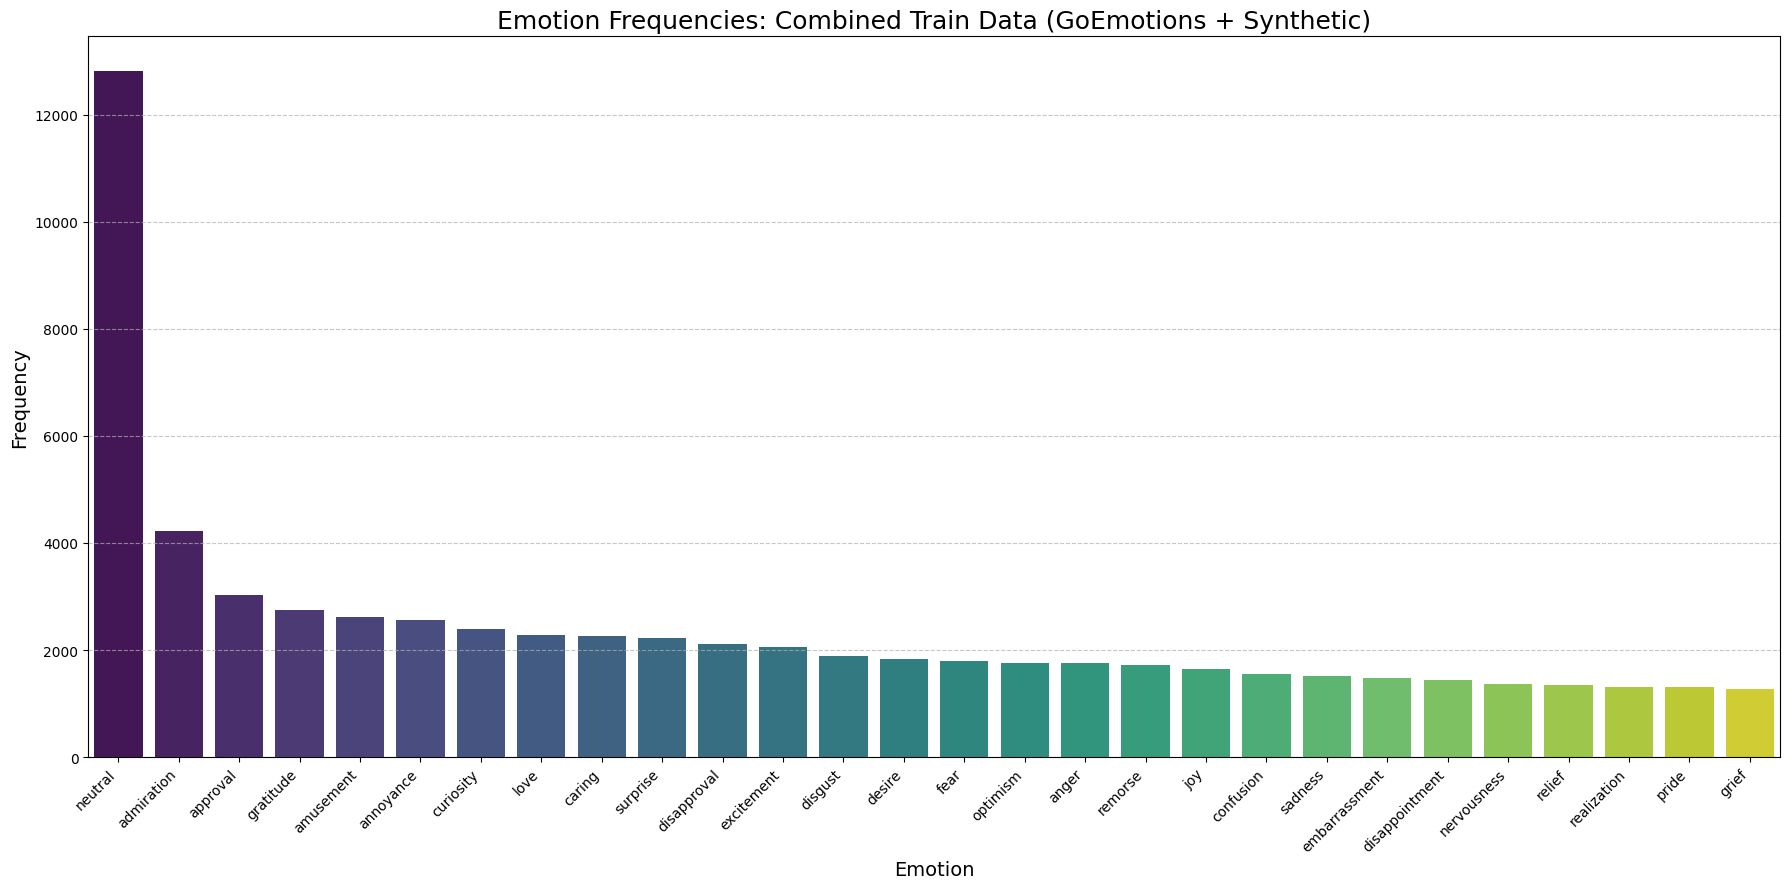

--------------------------------------------------------------------------------


In [53]:
# --- Verify the combined dataset's emotion frequencies ---
print("\n--- Verifying Combined Train Dataset Emotion Frequencies ---")
mlb = MultiLabelBinarizer(classes=GOEMOTIONS_LABELS)

if not train_df.empty:
    labels_binary = mlb.fit_transform(train_df['emotion'])

    df_labels_binary = pd.DataFrame(labels_binary, columns=mlb.classes_)

    combined_train_counts = df_labels_binary.sum().sort_values(ascending=False)

    print("\nEmotion Frequencies in the COMBINED TRAIN dataset:")
    print(combined_train_counts)

    plt.figure(figsize=(18, 9))
    sns.barplot(x=combined_train_counts.index, y=combined_train_counts.values, palette='viridis')
    plt.title('Emotion Frequencies: Combined Train Data (GoEmotions + Synthetic)', fontsize=18)
    plt.xlabel('Emotion', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Combined train_df is empty. Cannot calculate and visualize frequencies.")
print("--------------------------------------------------------------------------------")

In [54]:
# --- Convert to Hugging Face Dataset ---
print("\n--- Converting to Hugging Face Dataset ---")

if not val_df.empty:
    val_labels_binary = mlb.transform(val_df['emotion'])
    val_hf_dataset = Dataset.from_pandas(pd.DataFrame({'text': val_df['text'], 'labels': val_labels_binary.tolist()}))
else:
    val_hf_dataset = Dataset.from_pandas(pd.DataFrame(columns=['text', 'labels']))

if not test_df.empty:
    test_labels_binary = mlb.transform(test_df['emotion'])
    test_hf_dataset = Dataset.from_pandas(pd.DataFrame({'text': test_df['text'], 'labels': test_labels_binary.tolist()}))
else:
    test_hf_dataset = Dataset.from_pandas(pd.DataFrame(columns=['text', 'labels']))

if not train_df.empty:
    train_hf_dataset = Dataset.from_pandas(pd.DataFrame({'text': train_df['text'], 'labels': labels_binary.tolist()}))
else:
    train_hf_dataset = Dataset.from_pandas(pd.DataFrame(columns=['text', 'labels']))


print("Hugging Face Datasets created.")
print(f"train_hf_dataset columns: {train_hf_dataset.column_names}")
print(f"val_hf_dataset columns: {val_hf_dataset.column_names}")
print(f"test_hf_dataset columns: {test_hf_dataset.column_names}")
print("--------------------------------------------------------------------------------")


--- Converting to Hugging Face Dataset ---
Hugging Face Datasets created.
train_hf_dataset columns: ['text', 'labels']
val_hf_dataset columns: ['text', 'labels']
test_hf_dataset columns: ['text', 'labels']
--------------------------------------------------------------------------------


In [55]:
# --- Undersampling of 'neutral' Class ---
print("\n--- Starting Undersampling of 'neutral' Class ---")

neutral_examples = []
other_emotion_examples = []

if not train_df.empty:
    for index, row in train_df.iterrows():
        if len(row['emotion']) == 1 and 'neutral' in row['emotion']:
            neutral_examples.append(row)
        else:
            other_emotion_examples.append(row)

    df_neutral_class = pd.DataFrame(neutral_examples)
    df_other_emotions_class = pd.DataFrame(other_emotion_examples)

    print(f"Original 'neutral' count in train_df: {len(df_neutral_class)}")
    print(f"Original other emotions count in train_df: {len(df_other_emotions_class)}")


--- Starting Undersampling of 'neutral' Class ---
Original 'neutral' count in train_df: 12823
Original other emotions count in train_df: 51403


In [56]:
target_neutral_count = 2750
if len(df_neutral_class) > target_neutral_count:
    df_neutral_undersampled = df_neutral_class.sample(n=target_neutral_count, random_state=42)
    print(f"Undersampled 'neutral' from {len(df_neutral_class)} to {len(df_neutral_undersampled)} examples.")
else:
    df_neutral_undersampled = df_neutral_class
    print(f"'neutral' count ({len(df_neutral_class)}) is already at or below the target ({target_neutral_count}). No undersampling performed.")

train_df_undersampled = pd.concat([df_other_emotions_class, df_neutral_undersampled], ignore_index=True)

print(f"New combined (undersampled) train_df shape: {train_df_undersampled.shape}")

print("--- 'neutral' Undersampling Complete ---")
print("--------------------------------------------------------------------------------")

Undersampled 'neutral' from 12823 to 2750 examples.
New combined (undersampled) train_df shape: (54153, 5)
--- 'neutral' Undersampling Complete ---
--------------------------------------------------------------------------------


In [57]:
# --- Verify Undersampled Train Dataset Emotion Frequencies ---
print("\n--- Verifying Undersampled Train Dataset Emotion Frequencies ---")

mlb_undersampled = MultiLabelBinarizer(classes=GOEMOTIONS_LABELS)


--- Verifying Undersampled Train Dataset Emotion Frequencies ---


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['admiration, desire', 'amusement, joy', 'anticipation, excitement', 'approval, relief', 'caring, love', 'caring, relief', 'caring, sadness', 'confusion, curiosity', 'desire, excitement', 'disappointment, annoyance', 'disapproval, anger', 'disgust, annoyance', 'embarrassment, pride', 'embarrassment, sadness', 'fear, surprise', 'frustration, anger', 'gratitude, relief', 'grief, sadness', 'hope, optimism', 'loneliness, sadness', 'nervousness, embarrassment', 'nervousness, excitement', 'nervousness, fear', 'nervousness, grief', 'optimism, joy', 'pride, joy', 'pride, satisfaction', 'realization, surprise', 'relief, joy', 'remorse, sadness', 'shame, sadness'] will be ignored
  warnings.warn(
/tmp/ipython-input-58-2068896080.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=Fa


Emotion Frequencies in the UNDERSAMPLED TRAIN dataset:
admiration        4230
approval          3034
gratitude         2757
neutral           2750
amusement         2619
annoyance         2563
curiosity         2387
love              2281
caring            2265
surprise          2230
disapproval       2120
excitement        2053
disgust           1881
desire            1834
fear              1793
optimism          1766
anger             1764
remorse           1726
joy               1643
confusion         1555
sadness           1523
embarrassment     1478
disappointment    1450
nervousness       1361
relief            1339
realization       1308
pride             1303
grief             1271
dtype: int64


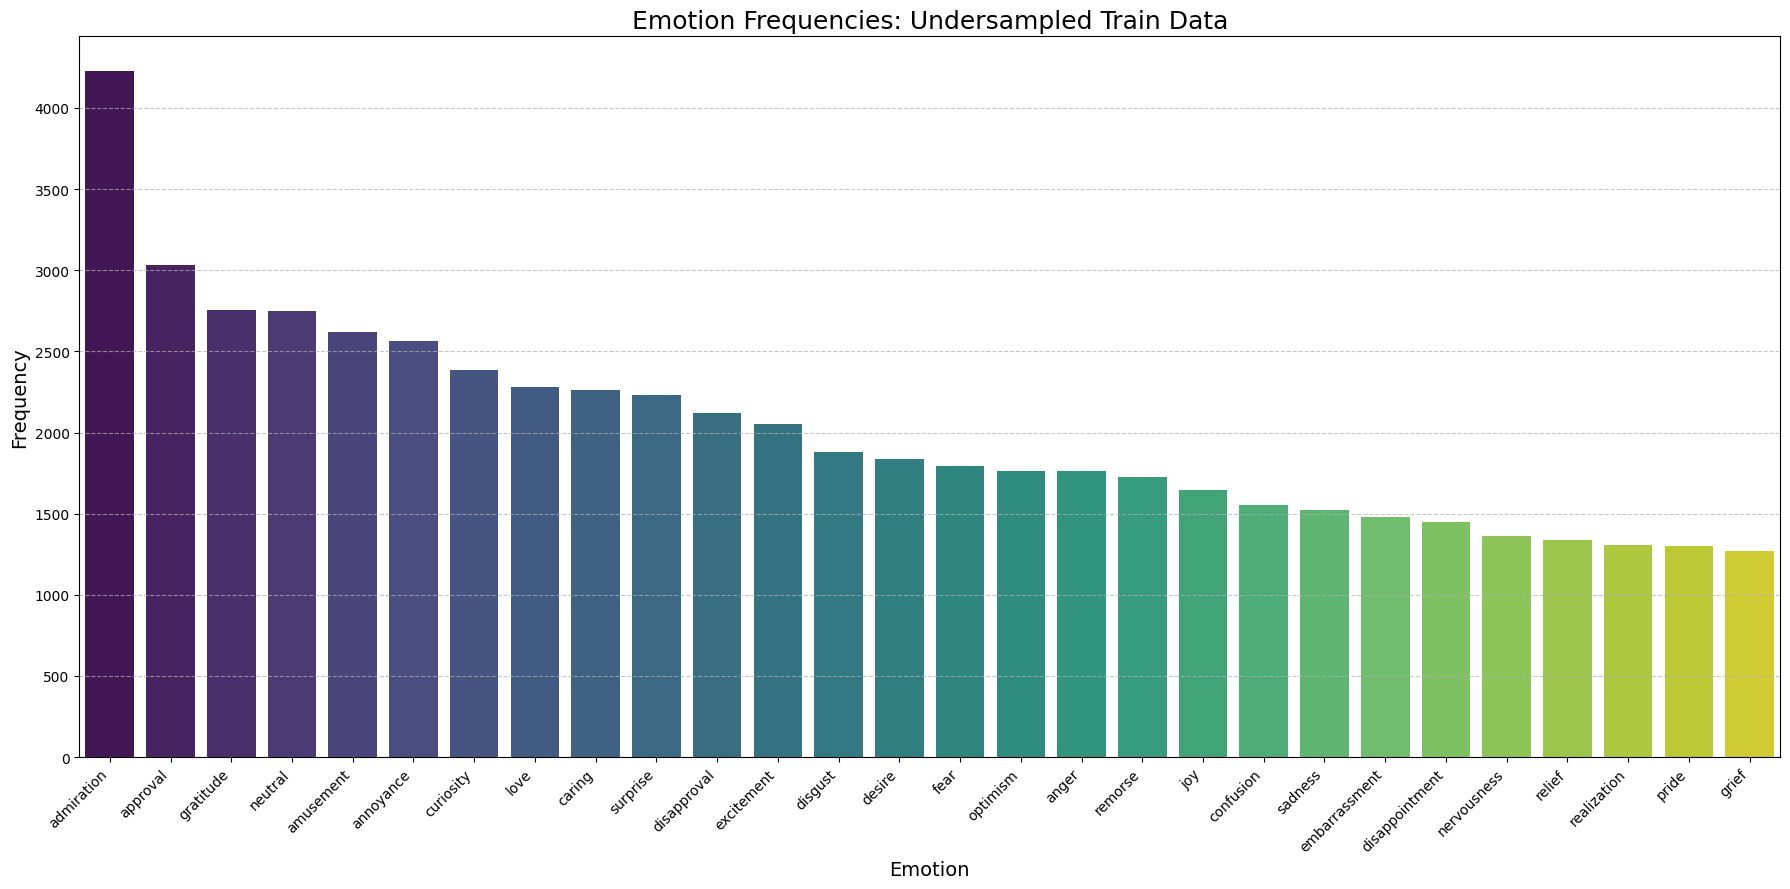


--- Converting Undersampled Train Dataset to Hugging Face Dataset ---
--------------------------------------------------------------------------------


In [58]:
if not train_df_undersampled.empty:
    labels_binary_undersampled = mlb_undersampled.fit_transform(train_df_undersampled['emotion'])

    df_labels_binary_undersampled = pd.DataFrame(labels_binary_undersampled, columns=mlb_undersampled.classes_)

    combined_train_counts_undersampled = df_labels_binary_undersampled.sum().sort_values(ascending=False)

    print("\nEmotion Frequencies in the UNDERSAMPLED TRAIN dataset:")
    print(combined_train_counts_undersampled)

    plt.figure(figsize=(18, 9))
    sns.barplot(x=combined_train_counts_undersampled.index, y=combined_train_counts_undersampled.values, palette='viridis')
    plt.title('Emotion Frequencies: Undersampled Train Data', fontsize=18)
    plt.xlabel('Emotion', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Undersampled train_df is empty. Cannot calculate and visualize frequencies.")


print("\n--- Converting Undersampled Train Dataset to Hugging Face Dataset ---")
print("--------------------------------------------------------------------------------")

In [59]:
# --- Convert Undersampled Train Dataset to Hugging Face Dataset ---
if not train_df_undersampled.empty:
    train_hf_dataset_undersampled = Dataset.from_pandas(
        pd.DataFrame({'text': train_df_undersampled['text'], 'labels': labels_binary_undersampled.tolist()})
    )
    print(f"train_hf_dataset_undersampled columns: {train_hf_dataset_undersampled.column_names}")
    print(f"train_hf_dataset_undersampled size: {len(train_hf_dataset_undersampled)}")
else:
    train_hf_dataset_undersampled = Dataset.from_pandas(pd.DataFrame(columns=['text', 'labels']))
    print("train_hf_dataset_undersampled is empty.")

print("\n--- Data Preparation for Training Complete ---")
print("--------------------------------------------------------------------------------")

train_hf_dataset_undersampled columns: ['text', 'labels']
train_hf_dataset_undersampled size: 54153

--- Data Preparation for Training Complete ---
--------------------------------------------------------------------------------


In [60]:
# --- Model Initialization ---
print("\n--- Initializing Model for Multi-label Classification ---")

model_checkpoint = "bert-base-uncased"
num_classes = len(GOEMOTIONS_LABELS)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_classes,
    problem_type="multi_label_classification"
)
print(f"Model '{model_checkpoint}' loaded for multi-label classification with {num_classes} labels.")
print("--------------------------------------------------------------------------------")


--- Initializing Model for Multi-label Classification ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model 'bert-base-uncased' loaded for multi-label classification with 28 labels.
--------------------------------------------------------------------------------


In [61]:
# --- Custom Loss Function (Focal Loss) ---
def focal_loss_with_logits(inputs, targets, alpha=0.25, gamma=2.0, pos_weight=None):
    bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none', pos_weight=pos_weight)
    prob = torch.sigmoid(inputs)
    p_t = prob * targets + (1 - prob) * (1 - targets)
    alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
    focal_term = (1 - p_t) ** gamma
    loss = alpha_t * focal_term * bce_loss
    return loss.mean()
print("Focal Loss function 'focal_loss_with_logits' defined.")
print("--------------------------------------------------------------------------------")

Focal Loss function 'focal_loss_with_logits' defined.
--------------------------------------------------------------------------------


In [62]:
# --- Custom Trainer for Loss Function Integration ---
class CustomTrainer(Trainer):
    def __init__(self, *args, loss_weights=None, focal_alpha=0.25, focal_gamma=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_weights = loss_weights
        self.focal_alpha = focal_alpha
        self.focal_gamma = focal_gamma
        super().__init__(*args, **kwargs)
        self.loss_weights = loss_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        weights_on_device = self.loss_weights.to(logits.device)
        loss = focal_loss_with_logits(
            inputs=logits,
            targets=labels.float(),
            alpha=self.focal_alpha,
            gamma=self.focal_gamma,
            pos_weight=weights_on_device
        )

        return (loss, outputs) if return_outputs else loss

print(f"Model '{model_checkpoint}' loaded for multi-label classification with {num_classes} labels.")
print("A CustomTrainer is defined to incorporate class weighting into the loss function.")
print("-----------------------------------------")

Model 'bert-base-uncased' loaded for multi-label classification with 28 labels.
A CustomTrainer is defined to incorporate class weighting into the loss function.
-----------------------------------------


In [63]:
# --- Tokenizer and Dataset Tokenization ---
print("\n--- Initializing Tokenizer and Tokenizing Datasets ---")
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    if 'text' not in examples:
        raise ValueError("The 'text' column is missing from the dataset examples.")
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

print("Tokenizing train dataset...")
tokenized_train_dataset = train_hf_dataset_undersampled.map(tokenize_function, batched=True)
print("Tokenizing validation dataset...")
tokenized_val_dataset = val_hf_dataset.map(tokenize_function, batched=True)
print("Tokenizing test dataset...")
tokenized_test_dataset = test_hf_dataset.map(tokenize_function, batched=True)

tokenized_train_dataset = tokenized_train_dataset.remove_columns(['text'])
tokenized_val_dataset = tokenized_val_dataset.remove_columns(['text'])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(['text'])

tokenized_train_dataset.set_format("torch")
tokenized_val_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")

print("Datasets tokenized and formatted for PyTorch.")
print(f"Tokenized train dataset features: {tokenized_train_dataset.column_names}")
print(f"Tokenized val dataset features: {tokenized_val_dataset.column_names}")
print(f"Tokenized test dataset features: {tokenized_test_dataset.column_names}")
print("-----------------------------------------")


--- Initializing Tokenizer and Tokenizing Datasets ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing train dataset...


Map:   0%|          | 0/54153 [00:00<?, ? examples/s]

Tokenizing validation dataset...


Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Tokenizing test dataset...


Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Datasets tokenized and formatted for PyTorch.
Tokenized train dataset features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
Tokenized val dataset features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
Tokenized test dataset features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
-----------------------------------------


In [64]:
# --- Calculate Class Weights ---
print("\n--- Calculating Class Weights ---")
labels_array = np.array(train_hf_dataset_undersampled['labels'])
label_counts = np.sum(labels_array, axis=0)
epsilon = 1e-6
total_samples_in_train = len(train_hf_dataset_undersampled)
num_classes = len(GOEMOTIONS_LABELS)

weights = np.zeros(num_classes)
for i, count in enumerate(label_counts):
    weights[i] = total_samples_in_train / (num_classes * (count + epsilon))

class_weights_tensor = torch.tensor(weights, dtype=torch.float)

print("Class Frequencies (from undersampled train_hf_dataset_undersampled):")
for i, label in enumerate(GOEMOTIONS_LABELS):
    print(f"- {label}: {label_counts[i]} (Calculated Weight: {class_weights_tensor[i]:.2f})")

print("-----------------------------------------")


--- Calculating Class Weights ---
Class Frequencies (from undersampled train_hf_dataset_undersampled):
- admiration: 4230 (Calculated Weight: 0.46)
- amusement: 2619 (Calculated Weight: 0.74)
- anger: 1764 (Calculated Weight: 1.10)
- annoyance: 2563 (Calculated Weight: 0.75)
- approval: 3034 (Calculated Weight: 0.64)
- caring: 2265 (Calculated Weight: 0.85)
- confusion: 1555 (Calculated Weight: 1.24)
- curiosity: 2387 (Calculated Weight: 0.81)
- desire: 1834 (Calculated Weight: 1.05)
- disappointment: 1450 (Calculated Weight: 1.33)
- disapproval: 2120 (Calculated Weight: 0.91)
- disgust: 1881 (Calculated Weight: 1.03)
- embarrassment: 1478 (Calculated Weight: 1.31)
- excitement: 2053 (Calculated Weight: 0.94)
- fear: 1793 (Calculated Weight: 1.08)
- gratitude: 2757 (Calculated Weight: 0.70)
- grief: 1271 (Calculated Weight: 1.52)
- joy: 1643 (Calculated Weight: 1.18)
- love: 2281 (Calculated Weight: 0.85)
- nervousness: 1361 (Calculated Weight: 1.42)
- optimism: 1766 (Calculated Weigh

In [65]:
# --- Define Evaluation Metrics ---
print("\n--- Defining Evaluation Metrics ---")

def compute_metrics(p):
    predictions = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    labels = p.label_ids
    probabilities = 1 / (1 + np.exp(-predictions))
    binary_predictions = (probabilities > 0.5).astype(int)
    macro_f1 = f1_score(labels, binary_predictions, average='macro', zero_division=0)
    macro_precision = precision_score(labels, binary_predictions, average='macro', zero_division=0)
    macro_recall = recall_score(labels, binary_predictions, average='macro', zero_division=0)

    micro_f1 = f1_score(labels, binary_predictions, average='micro', zero_division=0)
    micro_precision = precision_score(labels, binary_predictions, average='micro', zero_division=0)
    micro_recall = recall_score(labels, binary_predictions, average='micro', zero_division=0)

    return {
        "f1_macro": macro_f1,
        "precision_macro": macro_precision,
        "recall_macro": macro_recall,
        "f1_micro": micro_f1,
        "precision_micro": micro_precision,
        "recall_micro": micro_recall,
    }

print("Compute metrics function 'compute_metrics' defined (focusing on macro averages).")
print("-----------------------------------------")


--- Defining Evaluation Metrics ---
Compute metrics function 'compute_metrics' defined (focusing on macro averages).
-----------------------------------------


In [67]:
# --- Training Arguments ---
print("\n--- Setting up Training Arguments ---")
training_args = TrainingArguments(
    output_dir="./results/goemotions_model_v2",
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.02,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    dataloader_num_workers=2,
    report_to="wandb",
    fp16=torch.cuda.is_available(),
)

print("Training arguments defined.")
print("-----------------------------------------")


--- Setting up Training Arguments ---
Training arguments defined.
-----------------------------------------


In [68]:
# --- Trainer Initialization and Training ---
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.001
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [69]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    loss_weights=class_weights_tensor,
    focal_alpha=0.25,
    focal_gamma=2.0,
    callbacks=[early_stopping_callback],
)

In [70]:
trainer.train()

print("\n--- Training Complete ---")
print("-----------------------------------------")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,F1 Macro,Precision Macro,Recall Macro,F1 Micro,Precision Micro,Recall Micro
1,0.009100,0.009928,0.060413,0.231887,0.041921,0.092374,0.967846,0.048501



--- Training Complete ---
-----------------------------------------



--- Obtaining Validation Predictions for Threshold Analysis ---


Validation predictions obtained for threshold analysis.
Threshold | Macro F1 | Micro F1 | Macro P  | Micro P  | Macro R  | Micro R
----------------------------------------------------------------------
0.05      | 0.0742   | 0.0785   | 0.0408   | 0.0409   | 1.0000   | 1.0000
0.10      | 0.0846   | 0.0986   | 0.0465   | 0.0519   | 0.9780   | 0.9955
0.15      | 0.1755   | 0.2046   | 0.1038   | 0.1151   | 0.8752   | 0.9218
0.20      | 0.3276   | 0.3546   | 0.2313   | 0.2361   | 0.7069   | 0.7117
0.25      | 0.4159   | 0.4107   | 0.3871   | 0.3844   | 0.5151   | 0.4409
0.30      | 0.3879   | 0.3815   | 0.5252   | 0.5714   | 0.3590   | 0.2863
0.35      | 0.3166   | 0.3112   | 0.5678   | 0.7264   | 0.2556   | 0.1980
0.40      | 0.2422   | 0.2476   | 0.5842   | 0.8300   | 0.1819   | 0.1455
0.45      | 0.1421   | 0.1683   | 0.4385   | 0.9000   | 0.1023   | 0.0928
0.50      | 0.0604   | 0.0924   | 0.2319   | 0.9678   | 0.0419   | 0.0485
0.55      | 0.0246   | 0.0588   | 0.0357   | 1.0000   | 0.

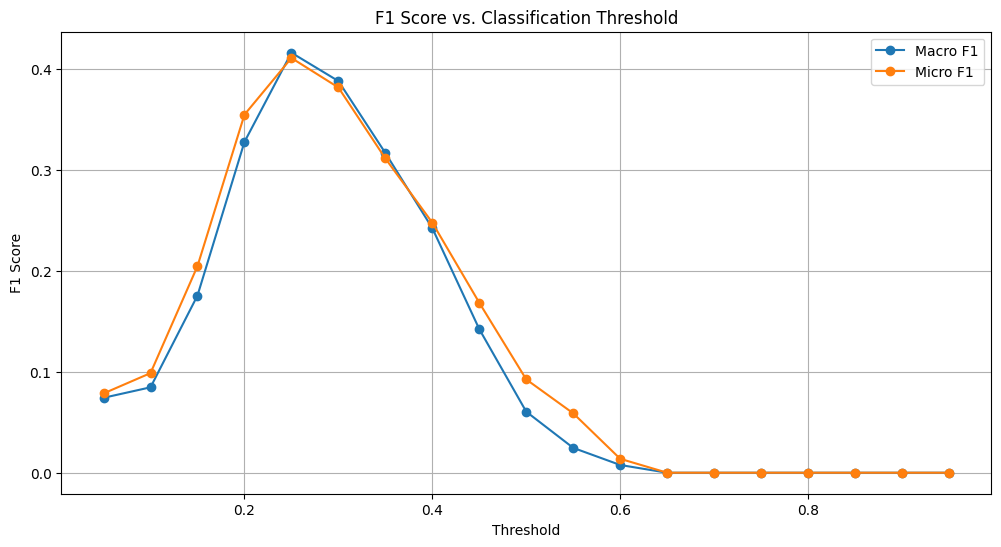


Optimal Threshold for Macro F1: 0.25
Max Macro F1 at this threshold: 0.4159
Corresponding Micro F1: 0.4107
-----------------------------------------


In [71]:
# ---Validation Predictions for Threshold Analysis---
print("\n--- Obtaining Validation Predictions for Threshold Analysis ---")

val_predictions_output = trainer.predict(tokenized_val_dataset)
val_logits = val_predictions_output.predictions
val_true = val_predictions_output.label_ids
val_probs = 1 / (1 + np.exp(-val_logits))

print("Validation predictions obtained for threshold analysis.")

thresholds = np.arange(0.05, 0.96, 0.05)

macro_f1_scores = []
micro_f1_scores = []
macro_precision_scores = []
micro_precision_scores = []
macro_recall_scores = []
micro_recall_scores = []

print("Threshold | Macro F1 | Micro F1 | Macro P  | Micro P  | Macro R  | Micro R")
print("-" * 70)

for t in thresholds:
    val_preds = (val_probs > t).astype(int)

    micro_f1 = f1_score(val_true, val_preds, average='micro', zero_division=0)
    macro_f1 = f1_score(val_true, val_preds, average='macro', zero_division=0)
    micro_p = precision_score(val_true, val_preds, average='micro', zero_division=0)
    macro_p = precision_score(val_true, val_preds, average='macro', zero_division=0)
    micro_r = recall_score(val_true, val_preds, average='micro', zero_division=0)
    macro_r = recall_score(val_true, val_preds, average='macro', zero_division=0)

    macro_f1_scores.append(macro_f1)
    micro_f1_scores.append(micro_f1)
    macro_precision_scores.append(macro_p)
    micro_precision_scores.append(micro_p)
    macro_recall_scores.append(macro_r)
    micro_recall_scores.append(micro_r)

    print(f"{t:.2f}      | {macro_f1:.4f}   | {micro_f1:.4f}   | {macro_p:.4f}   | {micro_p:.4f}   | {macro_r:.4f}   | {micro_r:.4f}")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(thresholds, macro_f1_scores, label='Macro F1', marker='o')
plt.plot(thresholds, micro_f1_scores, label='Micro F1', marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Classification Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the threshold that maximizes Macro F1
optimal_macro_f1_idx = np.argmax(macro_f1_scores)
optimal_threshold_macro_f1 = thresholds[optimal_macro_f1_idx]
print(f"\nOptimal Threshold for Macro F1: {optimal_threshold_macro_f1:.2f}")
print(f"Max Macro F1 at this threshold: {macro_f1_scores[optimal_macro_f1_idx]:.4f}")
print(f"Corresponding Micro F1: {micro_f1_scores[optimal_macro_f1_idx]:.4f}")
print("-----------------------------------------")

In [72]:
# ---Final Evaluation on Test Set---
print("\n--- Evaluating Model on Test Set ---")
final_test_results = trainer.evaluate(tokenized_test_dataset)
print(f"Final Test Set Evaluation Results: {final_test_results}")

# --- Add these lines to save the best model to Google Drive ---
# Make sure Google Drive is mounted at /content/drive
# from google.colab import drive
# drive.mount('/content/drive')

#model_save_path = "/content/drive/MyDrive/ML_Emotion_Classifier/emo_tag/" # Consider a new path for this model
#os.makedirs(model_save_path, exist_ok=True)
#trainer.save_model(model_save_path) # This saves the model and tokenizer
#print(f"Best model saved to {model_save_path} directory in your Google Drive.")
# --- Final Evaluation on Test Set ---
print(f"Final Test Set Evaluation Results: {final_test_results}")
print("--------------------------------------------------------------------------------")

#---Detailed classification report on Test Set---
print("\n--- Generating detailed classification report on Test Set ---")
predictions_output = trainer.predict(tokenized_test_dataset)
logits = predictions_output.predictions
true_labels = predictions_output.label_ids
optimal_threshold = 0.10 #
probabilities = 1 / (1 + np.exp(-logits))
predicted_labels = (probabilities >= optimal_threshold).astype(int)

report = classification_report(true_labels, predicted_labels,
                               target_names=GOEMOTIONS_LABELS,
                               zero_division='warn')
print(report)
print("\n--- Model Training and Evaluation Flow Complete ---")
print("---------------------------------------------------------------")


--- Evaluating Model on Test Set ---


Final Test Set Evaluation Results: {'eval_loss': 0.009873032569885254, 'eval_f1_macro': 0.06430337507029486, 'eval_precision_macro': 0.23926971326164873, 'eval_recall_macro': 0.04525019567435991, 'eval_f1_micro': 0.08718585169097115, 'eval_precision_micro': 0.9429530201342282, 'eval_recall_micro': 0.04570592062459336, 'eval_runtime': 20.5469, 'eval_samples_per_second': 264.127, 'eval_steps_per_second': 8.274, 'epoch': 1.0}
Final Test Set Evaluation Results: {'eval_loss': 0.009873032569885254, 'eval_f1_macro': 0.06430337507029486, 'eval_precision_macro': 0.23926971326164873, 'eval_recall_macro': 0.04525019567435991, 'eval_f1_micro': 0.08718585169097115, 'eval_precision_micro': 0.9429530201342282, 'eval_recall_micro': 0.04570592062459336, 'eval_runtime': 20.5469, 'eval_samples_per_second': 264.127, 'eval_steps_per_second': 8.274, 'epoch': 1.0}
--------------------------------------------------------------------------------

--- Generating detailed classification report on Test Set ---
  

In [73]:
# --- Define the prediction function here ---
def predict_emotions(text, model, tokenizer, labels, threshold=0.5):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
    inputs = {name: tensor.to(model.device) for name, tensor in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probabilities = torch.sigmoid(logits).squeeze().cpu().numpy()
    prob_dict = dict(zip(labels, probabilities))
    predicted_labels = [label for label, prob in prob_dict.items() if prob >= threshold]

    return predicted_labels, prob_dict

In [74]:
# --- Test Questions Post-Training ---
print("\n--- Testing Model with Custom Inputs ---")

trained_model = model
trained_tokenizer = tokenizer

GOEMOTIONS_LABELS = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
    'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment',
    'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
    'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

trained_model.config.id2label = {i: label for i, label in enumerate(GOEMOTIONS_LABELS)}
trained_model.config.label2id = {label: i for i, label in enumerate(GOEMOTIONS_LABELS)}

if trained_model and trained_tokenizer:
    model_labels = list(trained_model.config.id2label.values())

    # Scenario 1: A complex emotional text
    text1 = "I am so incredibly happy with this result, it truly fills me with joy and a sense of pride!"
    predicted_labels1, probs1 = predict_emotions(text1, trained_model, trained_tokenizer, model_labels, threshold=optimal_threshold_macro_f1)
    print("\n--- Test Scenario 1 ---")
    print(f"Text: '{text1}'")
    print(f"Predicted Emotions: {predicted_labels1}")
    sorted_probs1 = sorted(probs1.items(), key=lambda item: item[1], reverse=True)
    print(f"Top Probabilities: {sorted_probs1[:5]}") # Print top 5 probabilities

    # Scenario 2: A seemingly neutral text that might have subtle underlying emotion or be truly neutral
    text2 = "The sky is blue today. It's a typical Tuesday afternoon."
    predicted_labels2, probs2 = predict_emotions(text2, trained_model, trained_tokenizer, model_labels, threshold=optimal_threshold_macro_f1)
    print("\n--- Test Scenario 2 ---")
    print(f"Text: '{text2}'")
    print(f"Predicted Emotions: {predicted_labels2}")
    sorted_probs2 = sorted(probs2.items(), key=lambda item: item[1], reverse=True)
    print(f"Top Probabilities: {sorted_probs2[:5]}")

   # Scenario 3: A text with a negative or mixed emotion
    text3 = "I'm quite annoyed by the constant noise, but also a bit sad it has come to this."
    predicted_labels3, probs3 = predict_emotions(text3, trained_model, trained_tokenizer, model_labels, threshold=optimal_threshold_macro_f1)
    print("\n--- Test Scenario 3 ---")
    print(f"Text: '{text3}'")
    print(f"Predicted Emotions: {predicted_labels3}")
    sorted_probs3 = sorted(probs3.items(), key=lambda item: item[1], reverse=True)
    print(f"Top Probabilities: {sorted_probs3[:5]}")

else:
    print("\nSkipping prediction examples as model/tokenizer are not yet ready.")

print("\n--- Model Training, Evaluation, and Custom Prediction Flow Complete ---")
print("---------------------------------------------------------------")


--- Testing Model with Custom Inputs ---

--- Test Scenario 1 ---
Text: 'I am so incredibly happy with this result, it truly fills me with joy and a sense of pride!'
Predicted Emotions: ['pride']
Top Probabilities: [('pride', np.float32(0.38618454)), ('excitement', np.float32(0.21190567)), ('joy', np.float32(0.19406214)), ('amusement', np.float32(0.18877223)), ('admiration', np.float32(0.1821344))]

--- Test Scenario 2 ---
Text: 'The sky is blue today. It's a typical Tuesday afternoon.'
Predicted Emotions: ['admiration']
Top Probabilities: [('admiration', np.float32(0.27542195)), ('joy', np.float32(0.24798745)), ('approval', np.float32(0.20866229)), ('excitement', np.float32(0.18952109)), ('neutral', np.float32(0.1799625))]

--- Test Scenario 3 ---
Text: 'I'm quite annoyed by the constant noise, but also a bit sad it has come to this.'
Predicted Emotions: ['sadness']
Top Probabilities: [('sadness', np.float32(0.3824874)), ('disappointment', np.float32(0.20721471)), ('grief', np.float3